In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

In [2]:
# Carregar o arquivo MAT
data = scipy.io.loadmat('Dataset_Grupo7.mat')

In [3]:
# Extrair corretamente os dados relevantes (segunda coluna)
tempo = data['TARGET_DATA____ProjetoC213_Degrau'][:, 0]  # Primeira coluna para o tempo
degrau = data['TARGET_DATA____ProjetoC213_Degrau'][:, 1]  # Segunda coluna para os valores do degrau de entrada
saida_motor = data['TARGET_DATA____ProjetoC213_PotenciaMotor'][:, 1]  # Segunda coluna para os valores da saída do motor


In [4]:
# Calcular o valor final da resposta e a amplitude do degrau
amplitude_degrau = degrau[-1]
valor_final = saida_motor[-1]

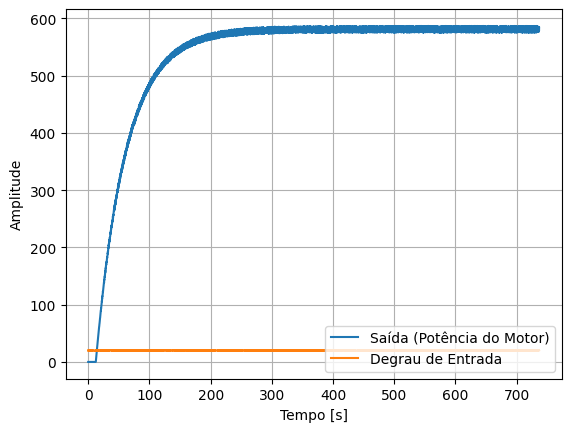

In [5]:
# Plotar a resposta de entrada e saída
plt.figure()
plt.plot(tempo, saida_motor, label='Saída (Potência do Motor)')
plt.plot(tempo, degrau, label='Degrau de Entrada')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [6]:
# Cálculo do ganho estático
ganho_estatico = valor_final / amplitude_degrau


In [7]:
# Função para estimar K, Tau, e Theta utilizando o método de Smith ou Sundaresan
def identificacaoSmithSundaresan(Step, Tempo, Saida, Metodo):
    K = valor_final / amplitude_degrau
    tempo_t1 = 0
    tempo_t2 = 0

    if Metodo == "Smith":
        for i in range(len(Saida)):
            if Saida[i] >= 0.283 * valor_final and tempo_t1 == 0:
                tempo_t1 = Tempo[i]
            if Saida[i] >= 0.632 * valor_final:
                tempo_t2 = Tempo[i]
                break
        tau = 1.5 * (tempo_t2 - tempo_t1)
        theta = tempo_t2 - tau
    else:
        # Método de Sundaresan
        for i in range(len(Saida)):
            if Saida[i] >= 0.353 * valor_final and tempo_t1 == 0:
                tempo_t1 = Tempo[i]
            if Saida[i] >= 0.853 * valor_final:
                tempo_t2 = Tempo[i]
                break
        aux = 2 / 3
        tau = aux * (tempo_t2 - tempo_t1)
        theta = 1.3 * tempo_t1 - 0.29 * tempo_t2
    return K, tau, theta


In [8]:
# Estimando parâmetros utilizando Smith e Sundaresan
K, tau_smith, theta_smith = identificacaoSmithSundaresan(degrau, tempo, saida_motor, "Smith")
K, tau_sundaresan, theta_sundaresan = identificacaoSmithSundaresan(degrau, tempo, saida_motor, "Sundaresan")


In [9]:
# Cálculo do erro para o método de Smith
sistema = ctl.tf(K, [tau_smith, 1])
num_delay, den_delay = ctl.pade(theta_smith, 20)
sistema_com_theta = ctl.series(ctl.tf(num_delay, den_delay), sistema)
tempo_simulado, saida_simulada = ctl.step_response(sistema_com_theta * amplitude_degrau, tempo)

erro_smith = np.sqrt(np.mean((saida_simulada - saida_motor) ** 2))


In [10]:
# Cálculo do erro para o método de Sundaresan
sistema = ctl.tf(K, [tau_sundaresan, 1])
num_delay, den_delay = ctl.pade(theta_sundaresan, 20)
sistema_com_theta = ctl.series(ctl.tf(num_delay, den_delay), sistema)
tempo_simulado, saida_simulada = ctl.step_response(sistema_com_theta * amplitude_degrau, tempo)

erro_sundaresan = np.sqrt(np.mean((saida_simulada - saida_motor) ** 2))

In [11]:
# Escolher o modelo com o menor erro
if erro_smith < erro_sundaresan:
    tau_estimado = tau_smith
    theta_estimado = theta_smith
    nome = "Smith"
    EQM = erro_smith
else:
    tau_estimado = tau_sundaresan
    theta_estimado = theta_sundaresan
    nome = "Sundaresan"
    EQM = erro_sundaresan

In [12]:
# Modelagem do sistema
sistema = ctl.tf(K, [tau_estimado, 1])
pade_aprox = ctl.pade(theta_estimado, 20)
sistema_com_theta = ctl.series(sistema, ctl.tf(*pade_aprox))
tempo_simulado, saida_simulada = ctl.step_response(sistema_com_theta * amplitude_degrau, tempo)

In [13]:
# Calcular o erro quadrático médio
erro_quadratico_medio = np.sqrt(np.mean((saida_simulada - saida_motor) ** 2))

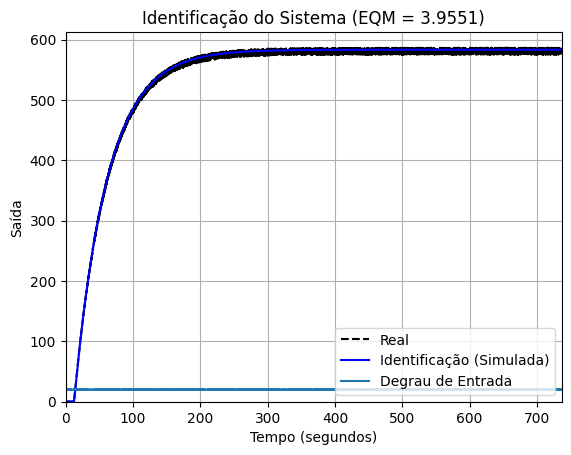

K = 29.0518623483324, Tau = 49.050000000000004, Theta = 12.449999999999996, EQM = 3.9551379921411445, Método = Smith


In [14]:
# Plotar a resposta real vs identificada
plt.figure()
plt.plot(tempo, saida_motor, 'k--', label='Real')
plt.plot(tempo_simulado, saida_simulada, label='Identificação (Simulada)', color='blue')
plt.plot(tempo, degrau, label='Degrau de Entrada')
plt.xlabel('Tempo (segundos)')
plt.xlim([0, len(tempo) * 0.1])
plt.ylabel('Saída')
plt.ylim([0, max(max(degrau), max(saida_simulada)) * 1.05])
plt.title(f'Identificação do Sistema (EQM = {erro_quadratico_medio:.4f})')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"K = {K}, Tau = {tau_estimado}, Theta = {theta_estimado}, EQM = {erro_quadratico_medio}, Método = {nome}")


In [15]:
# Função para plotar o gráfico
def grafico(tempo_res, sinal_res, tempo, Titulo):
    plt.figure(figsize=(8, 6))
    plt.plot(tempo_res, sinal_res * amplitude_degrau, label=Titulo)
    plt.plot(tempo_res, degrau, label='Degrau de Entrada')
    plt.xlabel('Tempo (segundos)')
    plt.xlim([0, len(tempo) * 0.1])
    plt.ylabel('Saída')
    plt.ylim(-1, 680)
    plt.title(Titulo)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

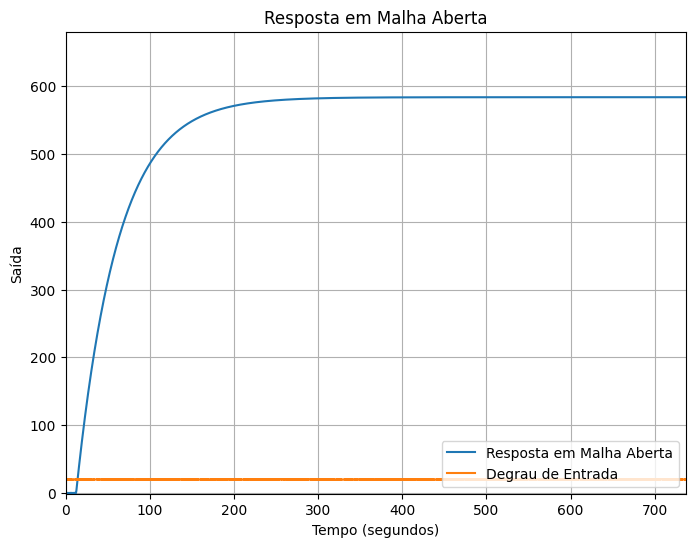

In [16]:
# Resposta em Malha Aberta
malha_aberta = ctl.tf([K], [tau_estimado, 1])
num_delay, den_delay = ctl.pade(theta_estimado, 20)
malha_aberta_com_theta = ctl.series(ctl.tf(num_delay, den_delay), malha_aberta)
tempo_aberta, saida_aberta = ctl.step_response(malha_aberta_com_theta, tempo)
grafico(tempo_aberta, saida_aberta, tempo, "Resposta em Malha Aberta")


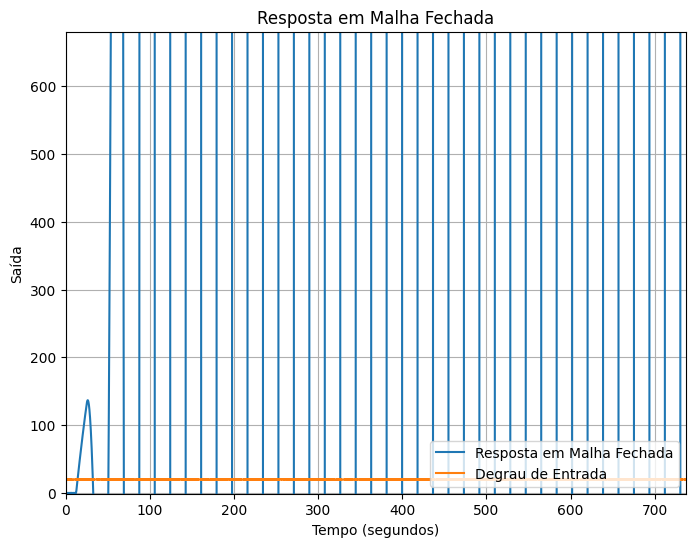

In [17]:
# Resposta em Malha Fechada
malha_fechada = ctl.feedback(malha_aberta_com_theta, 1)
tempo_fechada, saida_fechada = ctl.step_response(malha_fechada, tempo)
grafico(tempo_fechada, saida_fechada, tempo, "Resposta em Malha Fechada")

In [18]:
# Controlador CHR com Sobresinal
def CHR_com_sobrevalor(kp_chr, ti_chr, td_chr):
    print("\nCONTROLADOR - CHR COM TEMPO DE RESPOSTA")
    print(f"Kp = {kp_chr}, Td = {ti_chr}, Ti = {td_chr}.")
    
    pid_chr = [kp_chr * td_chr, kp_chr, kp_chr / ti_chr]
    den_chr = [1, 0]
    controlador_chr = ctl.tf(pid_chr, den_chr)
    
    controlador_chr_com_theta = ctl.series(ctl.tf(num_delay, den_delay), controlador_chr)
    sistema_com_theta = ctl.tf(K, [tau_estimado, 1])
    chr_completo = ctl.series(sistema_com_theta, controlador_chr_com_theta)
    
    sistema_chr_controlado = ctl.feedback(chr_completo, 1)
    tempo_chr, saida_chr = ctl.step_response(sistema_chr_controlado * amplitude_degrau, tempo)
    
    informacoes_chr = ctl.step_info(sistema_chr_controlado)
    
    # Obtendo o tempo de resposta ao invés do overshoot
    tempo_resposta_chr = informacoes_chr['RiseTime']
    print(f'Tempo de Resposta do CHR: {tempo_resposta_chr:.4f} segundos.')
    
    return tempo_chr, saida_chr


CONTROLADOR - CHR COM TEMPO DE RESPOSTA
Kp = 0.08136674314865171, Td = 49.050000000000004, Ti = 6.224999999999998.
Tempo de Resposta do CHR: 43.6869 segundos.


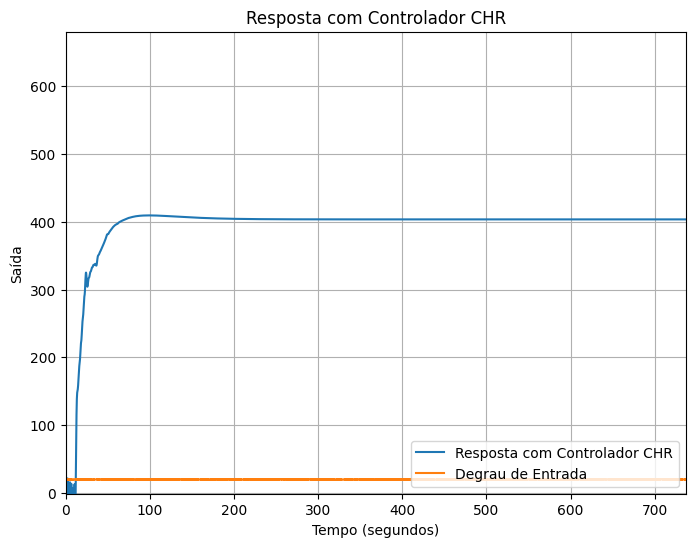

In [27]:
ti_chr = tau_estimado
td_chr = theta_estimado / 2
kp_chr = (0.6 * tau_estimado) / (K * theta_estimado)
temp_chr, sinal_resp_chr = CHR_com_sobrevalor(kp_chr, ti_chr, td_chr)
grafico(temp_chr, sinal_resp_chr, tempo, "Resposta com Controlador CHR")

In [20]:
# Controlador Cohen e Coon
def cohen_coon(kp_cc, ti_cc, td_cc):
    print("\nCONTROLADOR - COHEN E COON COM TEMPO DE RESPOSTA")
    print(f"Kp = {kp_cc}, Td = {td_cc}, Ti = {ti_cc}.")
    
    pid_cc = [kp_cc * td_cc, kp_cc, kp_cc / ti_cc]
    den_cc = [1, 0]
    controlador_cc = ctl.tf(pid_cc, den_cc)
    
    pid_cc_delay = ctl.series(ctl.tf(num_delay, den_delay), controlador_cc)
    
    sistema_com_theta = ctl.tf(K, [tau_estimado, 1])
    cohen_coon_completo = ctl.series(pid_cc_delay, sistema_com_theta)
    
    sistema_controlado = ctl.feedback(cohen_coon_completo, 1)
    tempo_cc, saida_cc = ctl.step_response(sistema_controlado * amplitude_degrau, tempo)
    
    informacoes_cc = ctl.step_info(sistema_controlado)
    
    # Obtendo o tempo de resposta ao invés do overshoot
    tempo_resposta_cc = informacoes_cc['RiseTime']
    print(f'Tempo de Resposta do Cohen e Coon: {tempo_resposta_cc:.4f} segundos.')
    
    return tempo_cc, saida_cc




CONTROLADOR - COHEN E COON COM TEMPO DE RESPOSTA
Kp = 0.1830751720844664, Td = 6.224999999999998, Ti = 19.62.
Tempo de Resposta do Cohen e Coon: 14.7862 segundos.


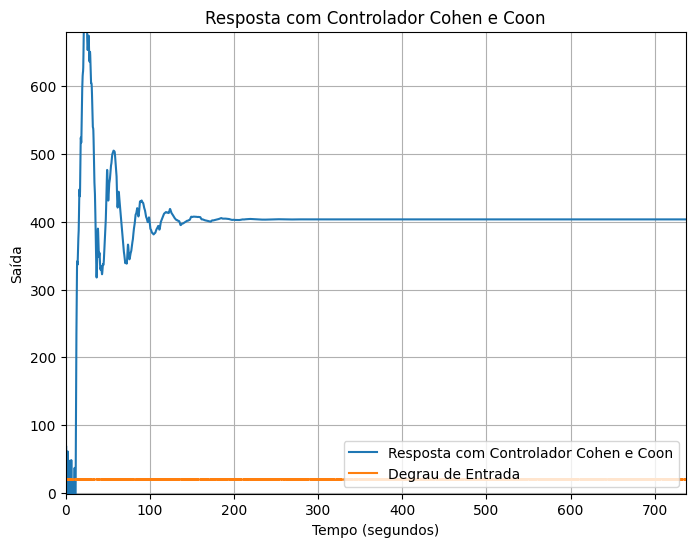

In [21]:
# Controlador Cohen e Coon - Parâmetros
kp_cc = (1.35 * tau_estimado) / (K * theta_estimado)
ti_cc = tau_estimado / (2.5)
td_cc = theta_estimado / 2
tempo_cc, saida_cc = cohen_coon(kp_cc, ti_cc, td_cc)
grafico(tempo_cc, saida_cc, tempo, "Resposta com Controlador Cohen e Coon")


In [28]:
# Função para ajuste dos controladores CHR e Cohen-Coon
def ajuste_CHR_Cohen_Coon(kp, ti, td):
    # Ajuste do CHR
    tempo_chr_ajust, saida_chr_ajust = CHR_com_sobrevalor(kp, ti, td)
    grafico(tempo_chr_ajust, saida_chr_ajust, tempo, "Resposta Ajustada com CHR com Sobresinal")
    
    # Ajuste do Cohen e Coon
    tempo_cc_ajust, saida_cc_ajust = cohen_coon(kp, ti, td)
    grafico(tempo_cc_ajust, saida_cc_ajust, tempo, "Resposta Ajustada com Cohen e Coon")


In [23]:
# Ajuste dos parâmetros do PID
def alterar_pid(tipo):
    print(f"\nAlterando PID por {tipo}")
    print("1 - Alterar Kp")
    print("2 - Alterar Ti")
    print("3 - Alterar Td")
    print("4 - Plotar")
    print("5 - Sair")

def pegar_valor(var):
    while True:
        try:
            valor = float(input(f"Valor {var}: "))
            if valor >= 0:
                return valor
            else:
                print("Valor incorreto, deve ser maior ou igual a zero.")
        except ValueError:
            print("Entrada inválida, insira um número válido.")

def menu_pid(tipo):
    while True:
        alterar_pid(tipo)
        aux = input("Escolha: ")
        
        if aux == '1':
            Kp = pegar_valor("Kp")
        elif aux == '2':
            Ti = pegar_valor("Ti")
        elif aux == '3':
            Td = pegar_valor("Td")
        elif aux == '4':
            print(f"\nKp = {Kp:.4f}, Ti = {Ti:.4f}, Td = {Td:.4f}.")
            if tipo == "CHR_com_sobrevalor":
                tempo_ajust, saida_ajust = CHR_com_sobrevalor(Kp, Ti, Td)
                grafico(tempo_ajust, saida_ajust, tempo, f"Resposta do PID Ajustado por CHR com Sobresinal")
            else:
                tempo_ajust, saida_ajust = cohen_coon(Kp, Ti, Td)
                grafico(tempo_ajust, saida_ajust, tempo, f"Resposta do PID Ajustado por Cohen e Coon")
        elif aux == '5':
            break
        else:
            print("Opção inválida.")

In [ ]:
print("\n Alterar PID. \n 1 - PID por CHR; \n 2 - PID por ITAE")
try:
    aux = int(input("Escolha: "))
    if aux == 1:
        menu_pid("CHR")
    elif aux == 2:
        menu_pid("ITAE")
    else:
        print("Opção inválida.")
except ValueError:
    print("Entrada inválida, escolha entre 1 ou 2.")